In [50]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch #for using tensors
import torch.nn as nn # creating neural network
import torch.nn.functional as F # recallable functions like relu,sigmoid and etc.
import torchvision # subpackage for vision models
import torchvision.transforms as transforms # image augmentation
import torch.optim as optim # optimisation functions like sgd, adam
from torch.utils.data import DataLoader # creating a data loader
from torchvision.transforms import ToTensor # converting image to tensor
import matplotlib.pyplot as plt 

In [79]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('Cuda is not available. Training on CPU')
else:
  print('Cuda is available. Training on GPU')

Cuda is not available. Training on CPU


In [47]:
train_path = '/content/drive/MyDrive/hmw11/seg_train'
test_path = '/content/drive/MyDrive/hmw11/seg_test'
pred_path = '/content/drive/MyDrive/hmw11/seg_pred'

transform = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dummy_label = 0

def get_label(path):
    return dummy_label

training_data = ImageFolder(root=train_path, transform=transform)
testing_data = ImageFolder(root=test_path, transform=transform)

try:
    prediction_data = ImageFolder(root=pred_path, transform=transform)
except FileNotFoundError:
    print(f"No directory or file found at {pred_path}")
    prediction_data = None

if prediction_data is not None and len(prediction_data) > 0:
    print(f"Found {len(prediction_data)} images for prediction.")
else:
    print(f"No images found for prediction in {pred_path}.")


No directory or file found at /content/drive/MyDrive/hmw11/seg_pred
No images found for prediction in /content/drive/MyDrive/hmw11/seg_pred.


In [48]:
training_data

Dataset ImageFolder
    Number of datapoints: 11935
    Root location: /content/drive/MyDrive/hmw11/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [49]:
training_data[1][0].size()

torch.Size([3, 150, 150])

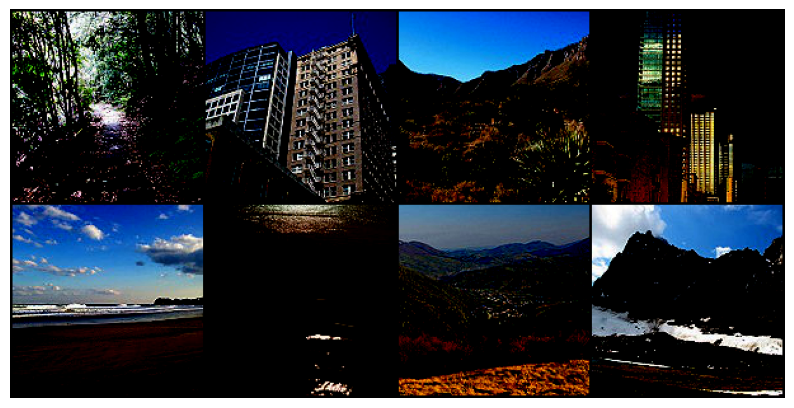

In [68]:
import random
import torchvision

# Get a batch of random images from the training data
batch = [random.choice(training_data) for i in range(8)]

# Create a grid of images
grid = torchvision.utils.make_grid([item[0] for item in batch], nrow=4)

# Display the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()


In [70]:
batch_size=64

In [71]:
train_loader = DataLoader(training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(testing_data,shuffle=True)

In [83]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Choosing 3 input channels because we have colored images as input
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=20,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=13,stride=2,padding=2)
        self.pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(128*16*16,256)
        self.fc2 = nn.Linear(256,256)
        #Choosing 6 for the output layer because we have 6 unique labels
        self.out = nn.Linear(256,6)
        self.drop_out = nn.Dropout()
    def forward(self,X):
        # input image size is [3,150,150]
        X = self.conv1(X)
        # (150-20+2*2)/1+1 -> 135
        # our result will be [64,135,135]
        X = self.conv2(X)
        # (135-13+2*2)/2 + 1 -> 64
        # [128,64,64]
        X = self.pool(X)
        # 64/4 -> 16
        # [128,16,16]
        X = X.reshape(X.size(0), -1)
        # [ 128*16*16] -> one dimension
        X = self.drop_out(X)
        # Regularization and preventing the co-adaptation of neurons
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [84]:
model=NeuralNetwork()

In [85]:
num_epochs = 12
learning_rate = 0.001

In [86]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [ ]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 3000 test images: {} %'.format((correct / total) * 100)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/hmw11/model.pth')